In [1]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import pylatexenc

import scipy.linalg as LA

from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator #import important Qiskit functions/modules and simulators


from qiskit.visualization import plot_histogram
import pylatexenc
from qiskit_ibm_runtime import QiskitRuntimeService #import qiskit plotting and real backend functions

import matplotlib.animation as animation
from matplotlib import rc

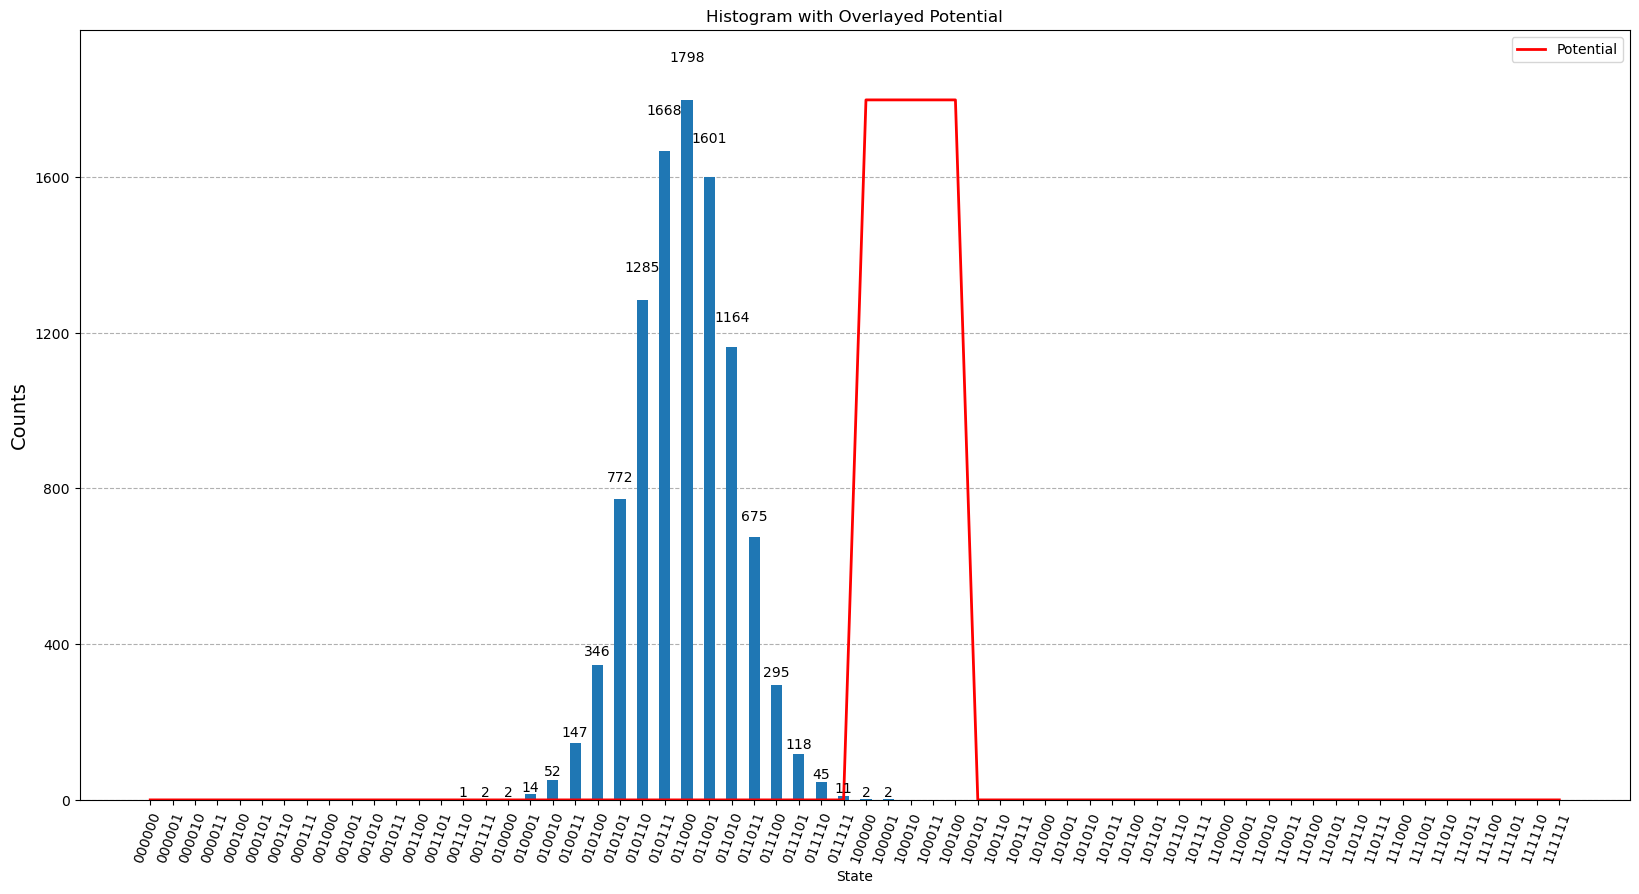

In [2]:
#Run at 0, 60, 120, 180 iterations

# Potential step from 100000 to 100100.

'''constants'''
n = 6  # number of qubits
N = 2**n  # grid points (must be a power of 2)
hbar = 1  # reduced Planck's constant
dt = 0.5
m = 1  # mass of particle in au

'''spatial grid'''
xMin = 0
xMax = 500
x = np.linspace(xMin, xMax, N)  # Adjust grid size to match N

'''momentum grid'''
p = np.arange(-N/2, N/2) * ((2 * np.pi * hbar) / (N * ((xMax - xMin) / (N - 1))))

'''wavefunction: Gaussian wavepacket'''
k0 = m / 2  # initial momentum
x0 = xMax / 2  -60  # initial position
sigma = (xMax - xMin) / 20  # width
psi = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-.5 * ((x - x0) / sigma)**2) * np.exp(1j * k0 * x)

'''Normalize the wavefunction'''
norm = np.linalg.norm(psi)
psi_normalized = psi / norm  # Normalize the state vector

'''potential operator + propagator'''
# Vhat = np.zeros_like(x)  # free particle
# Vhat[400:499] = 1  # add well between x = [400,499] (optional)
# Vprop = np.exp(-1j * dt * Vhat / (2 * hbar))  # half step



'''constants'''
phi = 0.1  # time step

'''potential'''
V = 1.5
qubits = QuantumRegister(n + 1)
splitOp = QuantumCircuit(qubits, name="splitOp")

'''potential operator'''
# Apply potential step only to states 100000 through 100100
# Convert binary states to integers, and apply controlled phase gates
for state in range(int("100000", 2), int("100100", 2) + 1):  # From 100000 to 100100
    binary_state = format(state, f"0{n}b")  # Convert to binary string of length n
    for i, bit in enumerate(reversed(binary_state)):  # Check each bit (LSB to MSB)
        if bit == "0":
            splitOp.x(qubits[i + 1])  # Flip qubits where binary_state has 0

    # Apply phase gate controlled by the binary state
    splitOp.mcx(qubits[1:], qubits[0])  # Multi-controlled NOT with target on qubit 0
    splitOp.p(V * phi, qubits[0])  # Phase gate on qubit 0
    splitOp.mcx(qubits[1:], qubits[0])  # Undo the multi-controlled NOT

    for i, bit in enumerate(reversed(binary_state)):  # Unflip qubits
        if bit == "0":
            splitOp.x(qubits[i + 1])

splitOp.barrier()


fig2 = splitOp.draw('mpl')
fig2.savefig('quantum_circuit.png')
'''QFT'''
splitOp.append(QFT(n),qubits[1:])
'''momentum operator'''
for i in range(n):
    splitOp.p(phi/2**(n-3+i), n-i)
for i in range(n):
    for j in range(i+1,n):
        splitOp.cx(n-j,0)
        splitOp.cx(n-i,0)
        splitOp.p(phi*(2**(2-i-j)),0)
        splitOp.cx(n-i,0)
        splitOp.cx(n-j,0)
'''inverse QFT'''
splitOp.append(QFT(n,inverse=True),qubits[1:]) #inverse QFT
splitOp.barrier()
#splitOp.draw('mpl')


q = QuantumRegister(n + 1)
c = ClassicalRegister(n)
circuit = QuantumCircuit(q, c)


'''initialization'''
circuit.initialize(psi_normalized, q[1:])  # Use the normalized state



circuit.barrier()

iterations = 0

'''time steps'''
for i in range(iterations):
    circuit.append(splitOp, q[:])

'''measurement'''
for i in range(1, n + 1):
    circuit.measure(i, i - 1)
    

'''Simulator setup and execution'''
simulator = AerSimulator()  # Use the AerSimulator
compiled_circuit = transpile(circuit, simulator)
sim_result = simulator.run(compiled_circuit, shots=10000).result()

# Get results
counts = sim_result.get_counts()

# Fill in missing states with 0
for a in range(N):
    s = bin(a)[2:]
    while len(s) != n:
        s = '0' + s
    if s not in counts.keys():
        counts[s] = 0

# Plot the results
# Potential definition
potential = np.zeros(N)
potential[32:37] = 1.5  # Add potential in the range [100000, 100100] (decimal indices)

# Normalize the potential to fit the histogram scale
max_count = max(counts.values())
normalized_potential = potential / max(potential) * max_count if max(potential) > 0 else potential

# Plot the histogram
fig, ax = plt.subplots(figsize=(20, 10))
plot_histogram(counts, ax=ax)

# Overlay the potential
ax.plot(range(N), normalized_potential, color='red', label='Potential', linewidth=2)

# Enhance the plot
ax.set_title("Histogram with Overlayed Potential")
ax.set_xlabel("State")
ax.set_ylabel("Counts")
ax.legend()

# Show the plot
plt.show()



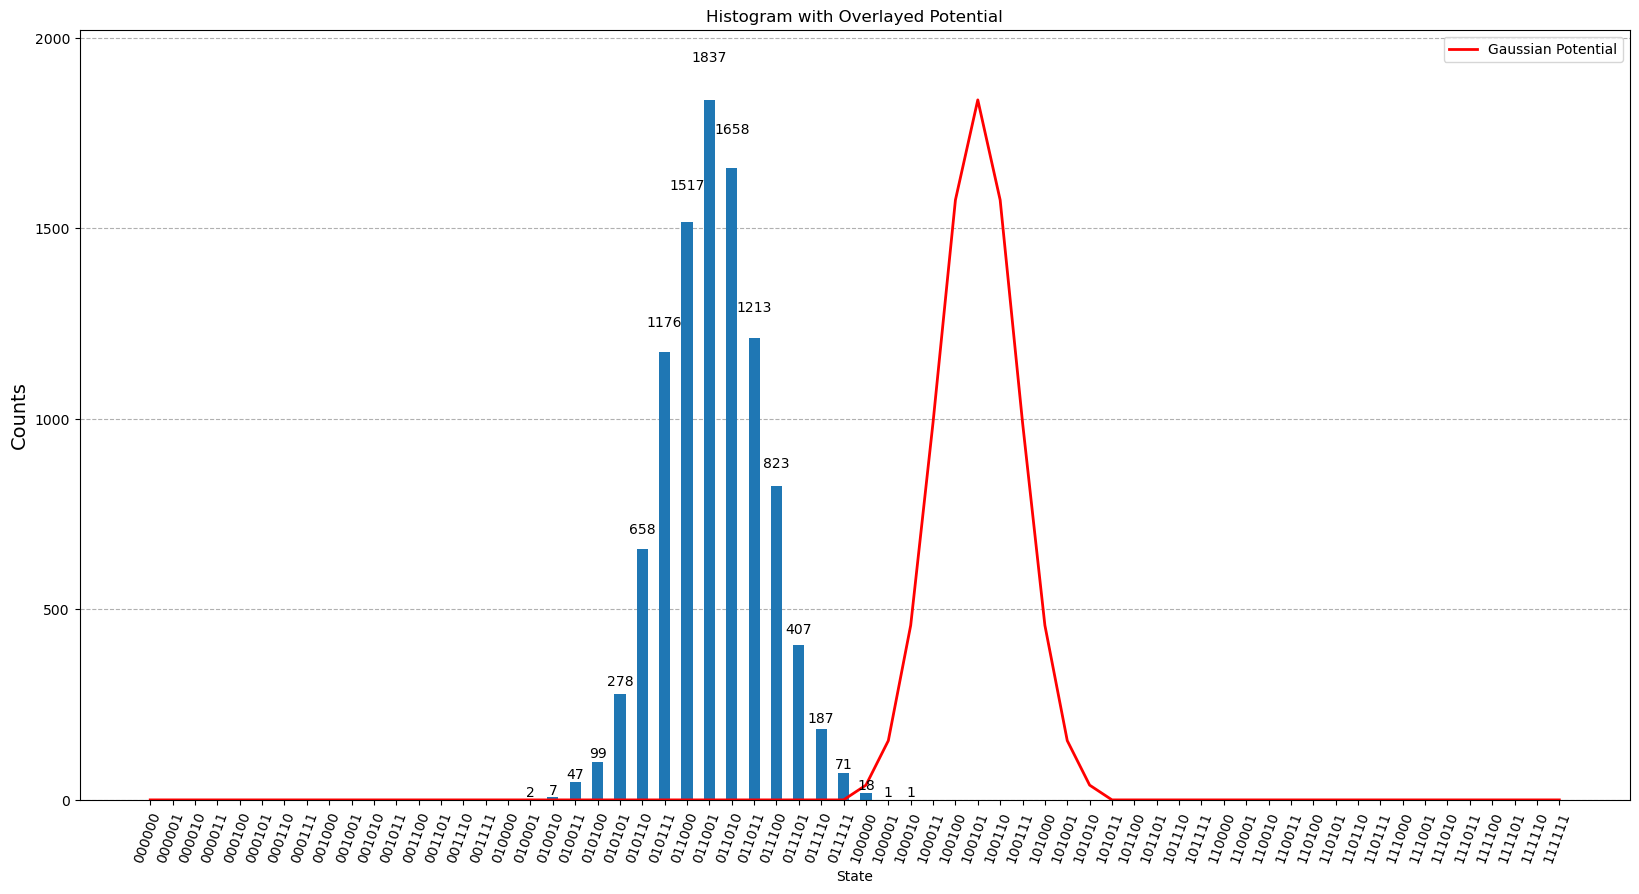

In [3]:
# Run at 0, 60, 120, 180 iterations
# Gaussian potential step


'''constants'''
n = 6  # number of qubits
N = 2**n  # grid points (must be a power of 2)
hbar = 1  # reduced Planck's constant
dt = 0.5
m = 1  # mass of particle in au

'''spatial grid'''
xMin = 0
xMax = 500
x = np.linspace(xMin, xMax, N)  # Adjust grid size to match N

'''momentum grid'''
p = np.arange(-N/2, N/2) * ((2 * np.pi * hbar) / (N * ((xMax - xMin) / (N - 1))))

'''wavefunction: Gaussian wavepacket'''
k0 = m / 2  # initial momentum
x0 = xMax / 2  -50  # initial position
sigma = (xMax - xMin) / 20  # width
psi = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-.5 * ((x - x0) / sigma)**2) * np.exp(1j * k0 * x)

'''Normalize the wavefunction'''
norm = np.linalg.norm(psi)
psi_normalized = psi / norm  # Normalize the state vector

'''potential operator + propagator'''
phi = 0.1  # time step

'''potential'''
V = 1.5
qubits = QuantumRegister(n + 1)
splitOp = QuantumCircuit(qubits, name="splitOp")

'''potential operator'''
# Define Gaussian parameters
center_state = (int("100000", 2) + int("101010", 2)) // 2  # Center of the Gaussian potential
sigma = 1.8  # Width of the Gaussian
V_max = V  # Maximum potential at the center

# Apply Gaussian potential step
for state in range(int("100000", 2), int("101010", 2) + 1):  # From 100000 to 101010
    binary_state = format(state, f"0{n}b")  # Convert to binary string of length n
    distance = state - center_state  # Distance from the center
    V_i = V_max * np.exp(-0.5 * (distance / sigma)**2)  # Gaussian potential

    # Flip qubits to prepare for controlled phase application
    for i, bit in enumerate(reversed(binary_state)):  # Check each bit (LSB to MSB)
        if bit == "0":
            splitOp.x(qubits[i + 1])  # Flip qubits where binary_state has 0

    # Apply phase gate scaled by the Gaussian potential
    splitOp.mcx(qubits[1:], qubits[0])  # Multi-controlled NOT with target on qubit 0
    splitOp.p(V_i * phi, qubits[0])  # Phase gate on qubit 0 with Gaussian-scaled potential
    splitOp.mcx(qubits[1:], qubits[0])  # Undo the multi-controlled NOT

    # Unflip qubits
    for i, bit in enumerate(reversed(binary_state)):
        if bit == "0":
            splitOp.x(qubits[i + 1])

splitOp.barrier()

'''QFT'''
splitOp.append(QFT(n), qubits[1:])

'''momentum operator'''
for i in range(n):
    splitOp.p(phi/2**(n-3+i), n-i)
for i in range(n):
    for j in range(i+1, n):
        splitOp.cx(n-j, 0)
        splitOp.cx(n-i, 0)
        splitOp.p(phi*(2**(2-i-j)), 0)
        splitOp.cx(n-i, 0)
        splitOp.cx(n-j, 0)

'''inverse QFT'''
splitOp.append(QFT(n, inverse=True), qubits[1:])  # inverse QFT
splitOp.barrier()

q = QuantumRegister(n + 1)
c = ClassicalRegister(n)
circuit = QuantumCircuit(q, c)

'''initialization'''
circuit.initialize(psi_normalized, q[1:])  # Use the normalized state
circuit.barrier()

iterations = 0

'''time steps'''
for i in range(iterations):
    circuit.append(splitOp, q[:])

'''measurement'''
for i in range(1, n + 1):
    circuit.measure(i, i - 1)

'''Simulator setup and execution'''
simulator = AerSimulator()  # Use the AerSimulator
compiled_circuit = transpile(circuit, simulator)
sim_result = simulator.run(compiled_circuit, shots=10000).result()

# Get results
counts = sim_result.get_counts()

# Fill in missing states with 0
for a in range(N):
    s = bin(a)[2:]
    while len(s) != n:
        s = '0' + s
    if s not in counts.keys():
        counts[s] = 0

# Plot the results
# Potential definition
# Define Gaussian potential for plotting



# Adjust the plotting code to match the new range
potential = np.zeros(N)
for state in range(int("100000", 2), int("101010", 2) + 1):
    distance = state - center_state
    potential[state] = V_max * np.exp(-0.5 * (distance / sigma)**2)

# Normalize the potential to fit the histogram scale
max_count = max(counts.values())
normalized_potential = potential / max(potential) * max_count if max(potential) > 0 else potential

# Plot the histogram
fig, ax = plt.subplots(figsize=(20, 10))
plot_histogram(counts, ax=ax)

# Overlay the potential
ax.plot(range(N), normalized_potential, color='red', label='Gaussian Potential', linewidth=2)

# Enhance the plot
ax.set_title("Histogram with Overlayed Potential")
ax.set_xlabel("State")
ax.set_ylabel("Counts")
ax.legend()

# Show the plot
plt.show()

